# Live Training for Pearson Learning
## Time Series Analysis and Forecasting for Beginners


## Section 3 and 4: Formulating ARIMA Model and ARIMA Modeling

### Topics in this section include 


* Model estimation and identification

* Model diagnostic Checking

* Model assumption testing

* Model performance evaluation (in-sample fit)

* Forecasting and forecast evaluation 

In [53]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

import sys
import os

import pandas as pd
import numpy as np

# TSA from Statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
def tsplot(y, title='TITLE', xlabel='X Label', ylabel='Y Label', figsize=(12, 8)):
    '''
    Plot the time series plot
    '''
    fig, ax = plt.subplots(figsize=figsize)
        
    y.plot(ax=ax)
    
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    sns.despine()
    fig.tight_layout()

In [55]:
def tsplot2(y, lags=None, title='', figsize=(16, 10)):
    '''Examine the patterns of ACF and PACF, along with the time series plot and histogram.
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax   = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax  = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

## Load the Series

In [56]:
# Import the csv file containing the series for the analysis

# U of Michigan Consumer Sentiment Series
sentiment = pd.read_csv('data/UMCSENT.csv', index_col=0, parse_dates=[0])

## 3.0 Examining the data

In [57]:
print(sentiment.shape)
print(sentiment.head())

(235, 1)
             UMCSENT
DATE                
2000-11-01 107.60000
2000-12-01  98.40000
2001-01-01  94.70000
2001-02-01  90.60000
2001-03-01  91.50000


<div class="alert alert-info"> 
    
<b>Note:</b> 

As in other notebooks, the (mathematical) notes in this notebook are meant for take-home review. For concepts and formulation set up using mathematical notations, I will discuss the formulation using my slides.

</div>

## 3.1 Model Identification (ARIMA Model Determination)

1. Determine the *degree of differencing*, $d$

2. Study the patterns of the ACF and PACF of the appropriately differenced series: $\omega_t = (1-B)^d z_t$, as these autocorrelation functions will provide indication for the choice of the order of autoregressive and the moving average components.  While we did not have enough time in this tutorial, it is very beneficial to study the *theoretical* ACF and PACF of the autoregressive, moving average, and the mixed autoregressive and moving average processes.

3. The table below summarize the patterns of the ACF and PACF associated with the $AR(p)$, $MA(q)$, and $ARMA(p,q)$ processes:

|  Process      |          ACF         |          PACF        |
|---------------|:--------------------:|:--------------------:|
| **AR(p)**     |    tails off         | cutoff after lag $p$ |
| **MA(q)**     | cutoff after lag $q$ |    tails off         |
| **ARMA(p,q)** |    tails off         |    tails off         |

4. In general, the ACF of an autoregressive process is similar to the PACF of a moving average process, and vice versa.
5. Keep in mind that these are theoretical properties. In practice, the estimated sample ACF and PACF can come with large variances, deviating from the underlying theoretical behavior. As such, it is prudent to recognize that these are  but broad characteristics, and it is quite possible that several candidate models are narrowed down and will need to be investigaged further in the later stage of the modeling process.

In [58]:
type(sentiment)

pandas.core.frame.DataFrame

In [59]:
# Create a training sample and testing sample before analyzing the series

# n_train = int(0.80*n_sample)+1
# n_forecast=n_sample-n_train
# ts_train = sentiment.iloc[:n_train]['value']
# ts_test = sentiment.iloc[n_train:]['value']

sentiment_train = sentiment['2011':'2019-06-01']
sentiment_test  = sentiment['2019-07-01':'2019-12-01']

print(sentiment_train.shape)
print(sentiment_test.shape)
print("Training Series:", "\n", sentiment_train.tail(), "\n")
print("Testing Series:", "\n", sentiment_test.head(6))
#print("Testing Series:", "\n", sentiment_test.tail())

(102, 1)
(6, 1)
Training Series: 
              UMCSENT
DATE                
2019-02-01  93.80000
2019-03-01  98.40000
2019-04-01  97.20000
2019-05-01 100.00000
2019-06-01  98.20000 

Testing Series: 
             UMCSENT
DATE               
2019-07-01 98.40000
2019-08-01 89.80000
2019-09-01 93.20000
2019-10-01 95.50000
2019-11-01 96.80000
2019-12-01 99.30000


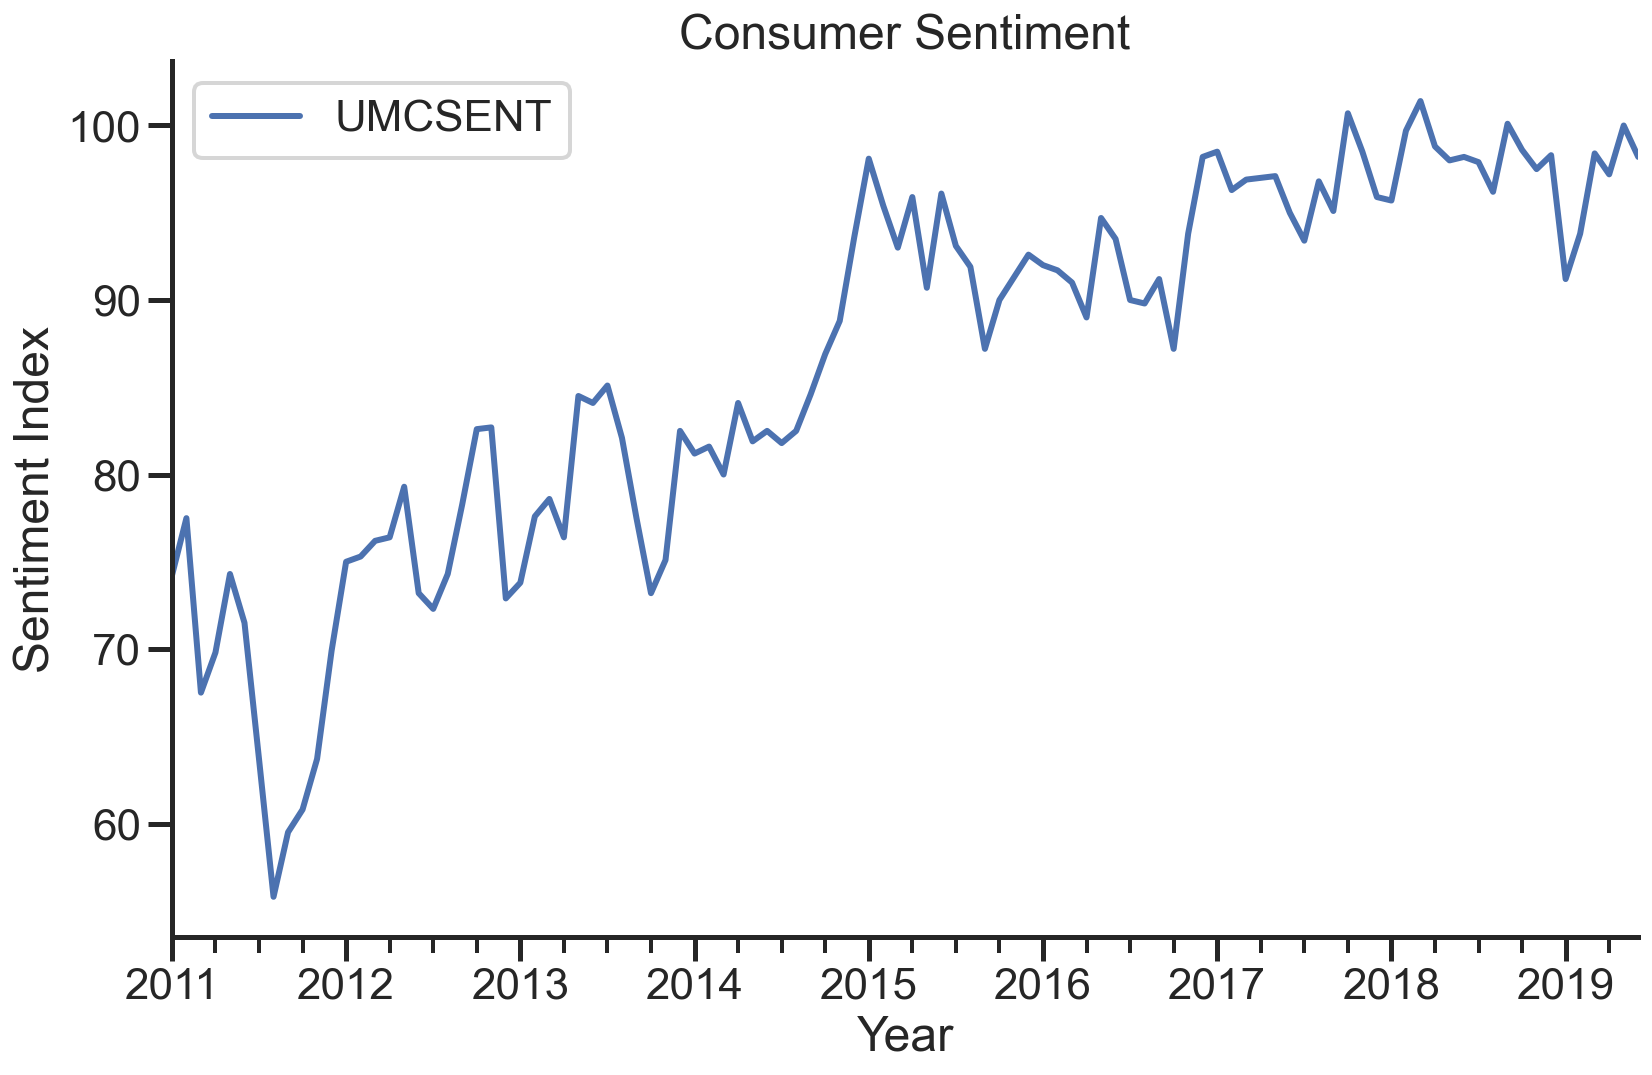

In [60]:
tsplot(sentiment['2011':'2019-06-01'],
      'Consumer Sentiment',
      'Year', 
      'Sentiment Index',
      (12,8))

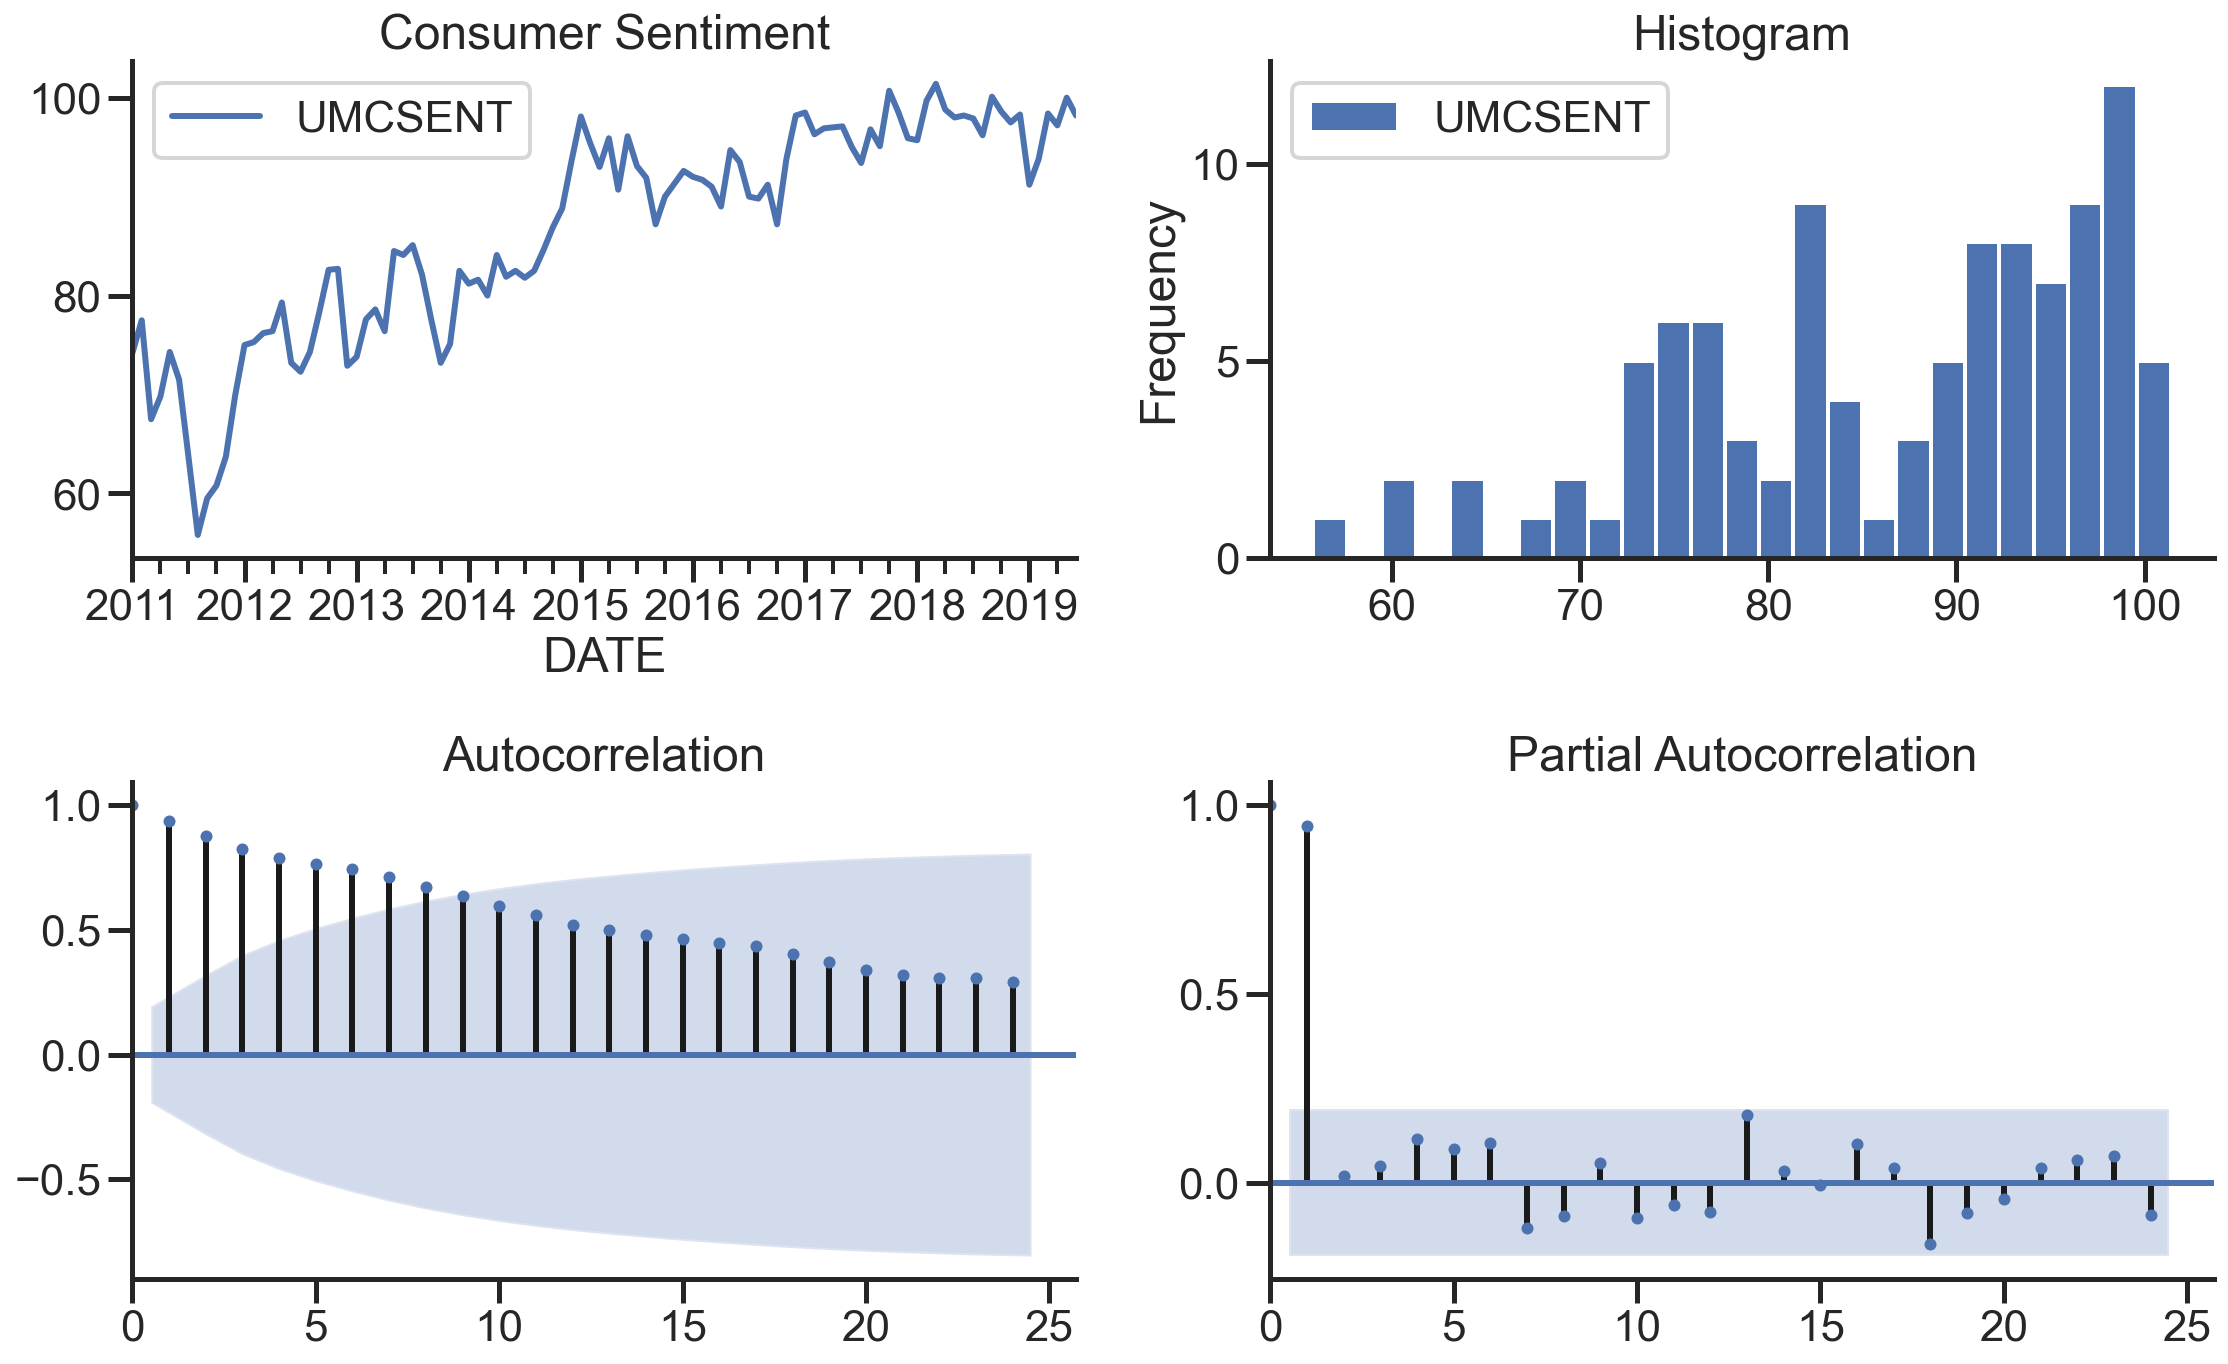

In [61]:
_ = tsplot2(sentiment_train, title='Consumer Sentiment', lags=24);

### 3.1.1 Take a first difference of the series

In [62]:
sentiment_train_diff = sentiment_train.diff(1)
sentiment_test_diff = sentiment_test.diff(1)

In [63]:
sentiment_train_diff.head()

,UMCSENT
DATE,
2011-01-01,NaN
2011-02-01,3.30000
2011-03-01,-10.00000
2011-04-01,2.30000
2011-05-01,4.50000


In [64]:
sentiment

,UMCSENT
DATE,
2000-11-01,107.60000
2000-12-01,98.40000
2001-01-01,94.70000
2001-02-01,90.60000
2001-03-01,91.50000
...,...
2020-01-01,99.80000
2020-02-01,101.00000
2020-03-01,89.10000


In [65]:
sentiment_train.diff(12).head(15)

,UMCSENT
DATE,
2011-01-01,NaN
2011-02-01,NaN
2011-03-01,NaN
2011-04-01,NaN
2011-05-01,NaN
2011-06-01,NaN
2011-07-01,NaN
2011-08-01,NaN
2011-09-01,NaN


In [66]:
sentiment_train_diff = sentiment_train_diff.dropna()
sentiment_test_diff = sentiment_test_diff.dropna()

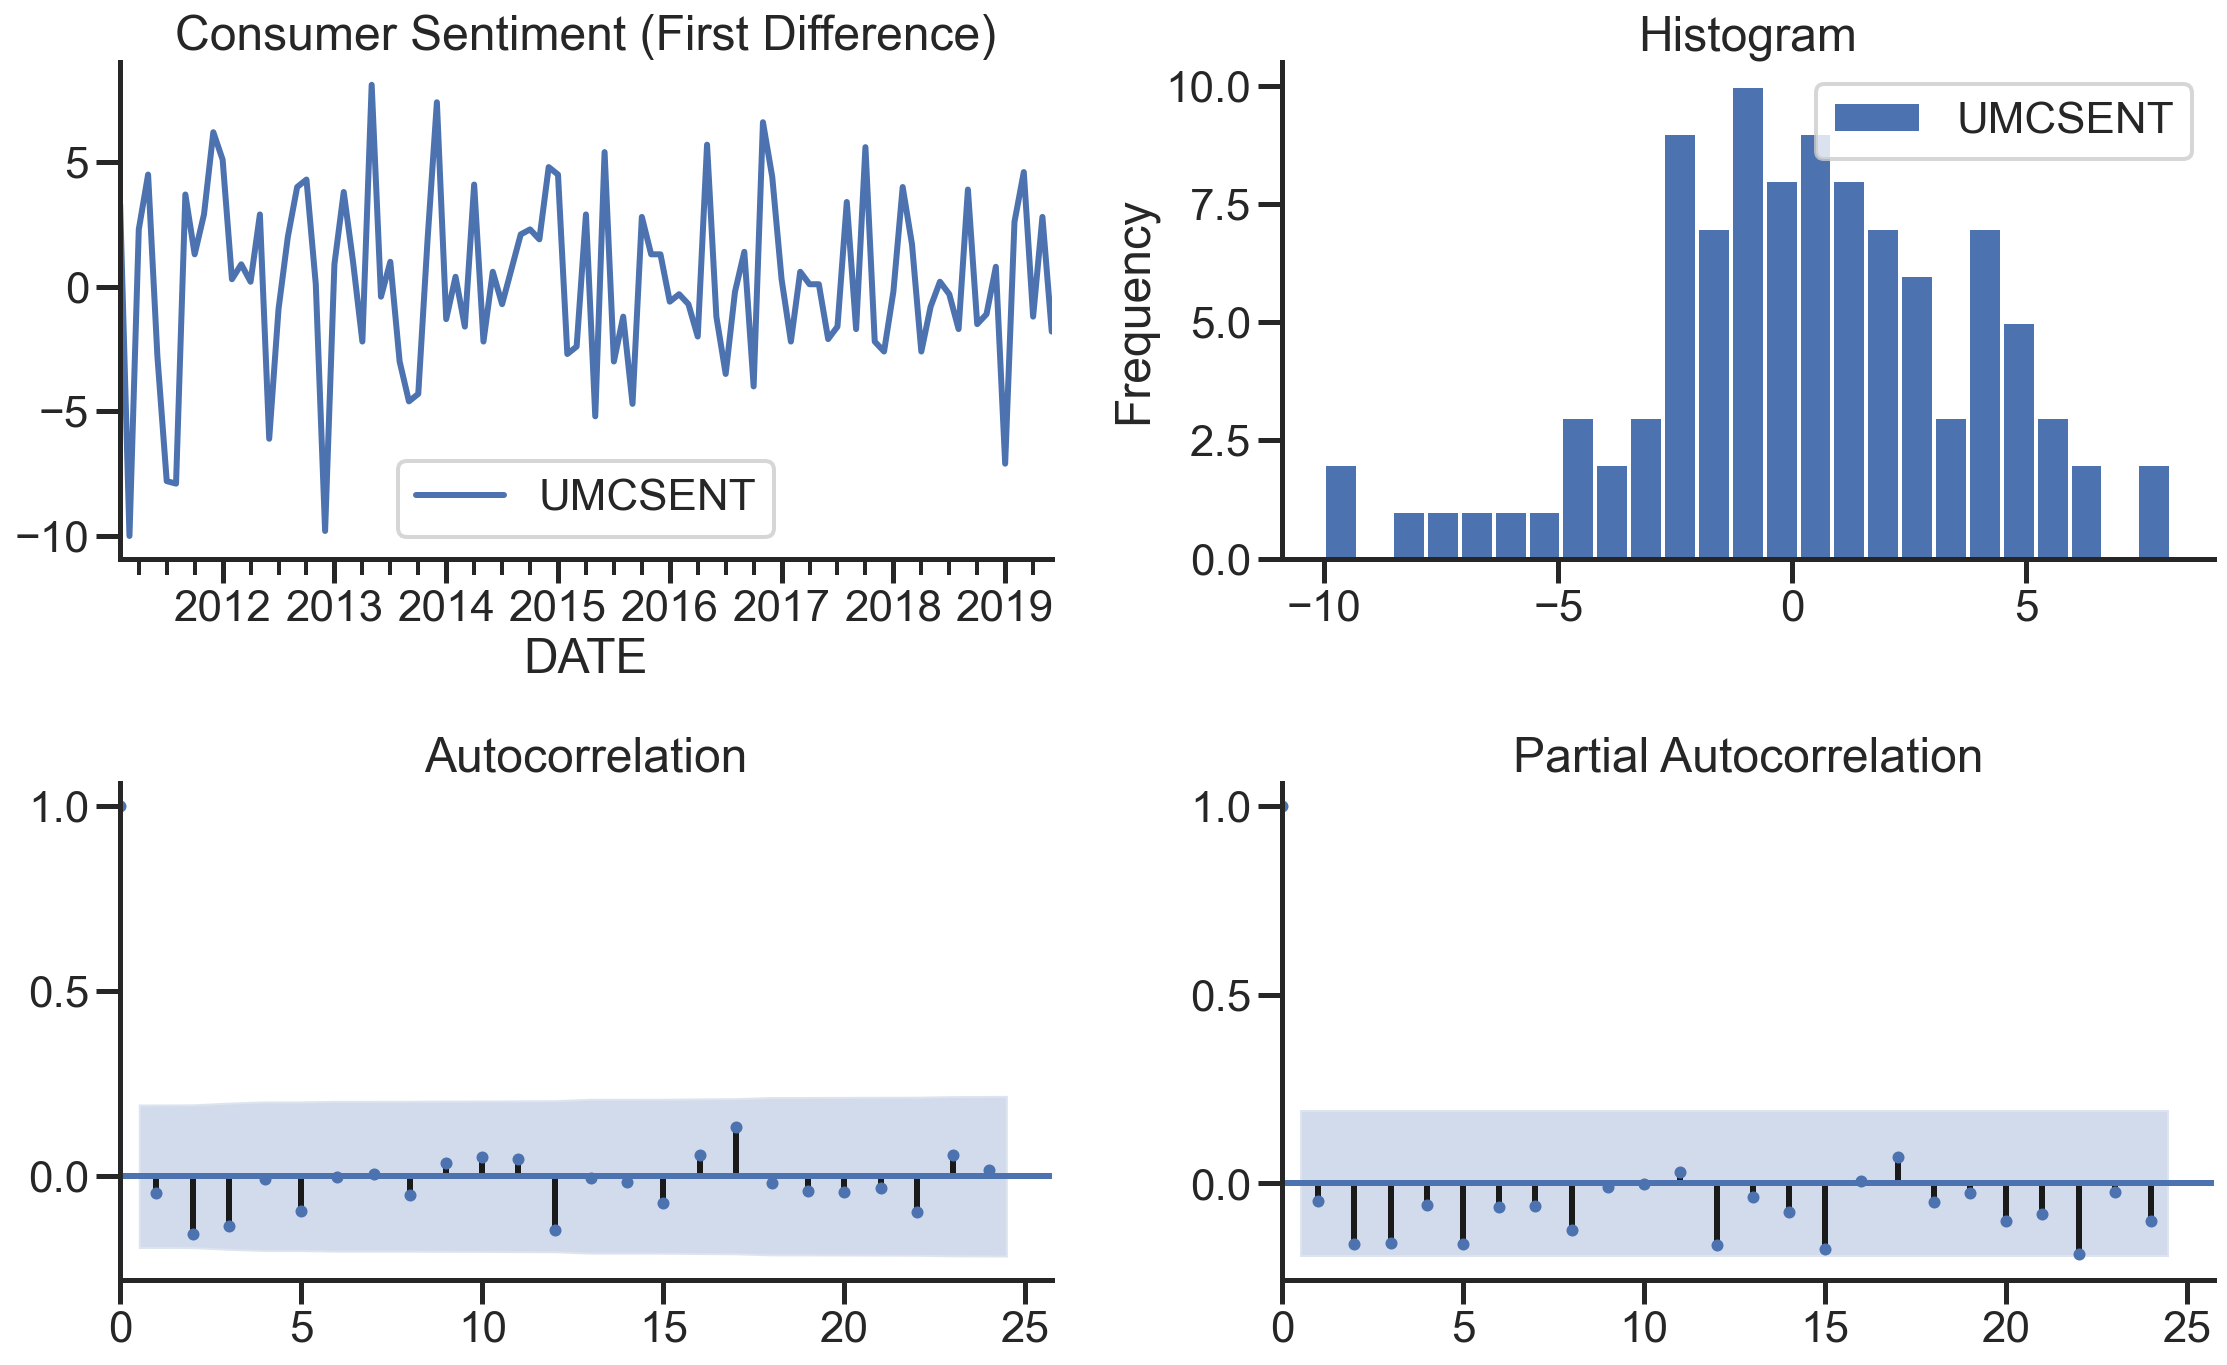

In [67]:
_ = tsplot2(sentiment_train_diff, title='Consumer Sentiment (First Difference)', lags=24);

## 3.2 Model Estimation

In [68]:
# Model Estimation
arima111 = sm.tsa.SARIMAX(sentiment_train, order=(1,1,1))
arima111_results = arima111.fit()
print(arima111_results.summary())

                               SARIMAX Results                                
Dep. Variable:                UMCSENT   No. Observations:                  102
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -268.912
Date:                Sat, 06 Mar 2021   AIC                            543.824
Time:                        01:41:41   BIC                            551.669
Sample:                    01-01-2011   HQIC                           547.000
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6774      0.175      3.866      0.000       0.334       1.021
ma.L1         -0.8479      0.130     -6.535      0.000      -1.102      -0.594
sigma2        12.0056      1.555      7.720      0.0

## Digression:

* In practice, one could *search* over a few models using the visual clues above as a starting point.  
* I will not go over this code in this lecture, but it gives a starting point and an example.
* Note that I used `BIC` in the code below, but some forecast researchers use `AICc` instead.

In [69]:
import itertools

p_min = 0
d_min = 0
q_min = 0
p_max = 3
d_max = 1
q_max = 3

# Initialize a DataFrame to store the results
results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                           columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                               range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = np.nan
        continue
    
    try:
        model = sm.tsa.SARIMAX(sentiment_train, order=(p, d, q),
                               enforce_stationarity=False,
                               enforce_invertibility=False,
                              )
        results = model.fit()
        results_bic.loc['AR{}'.format(p), 'MA{}'.format(q)] = results.bic
    except:
        continue

results_bic = results_bic[results_bic.columns].astype(float)

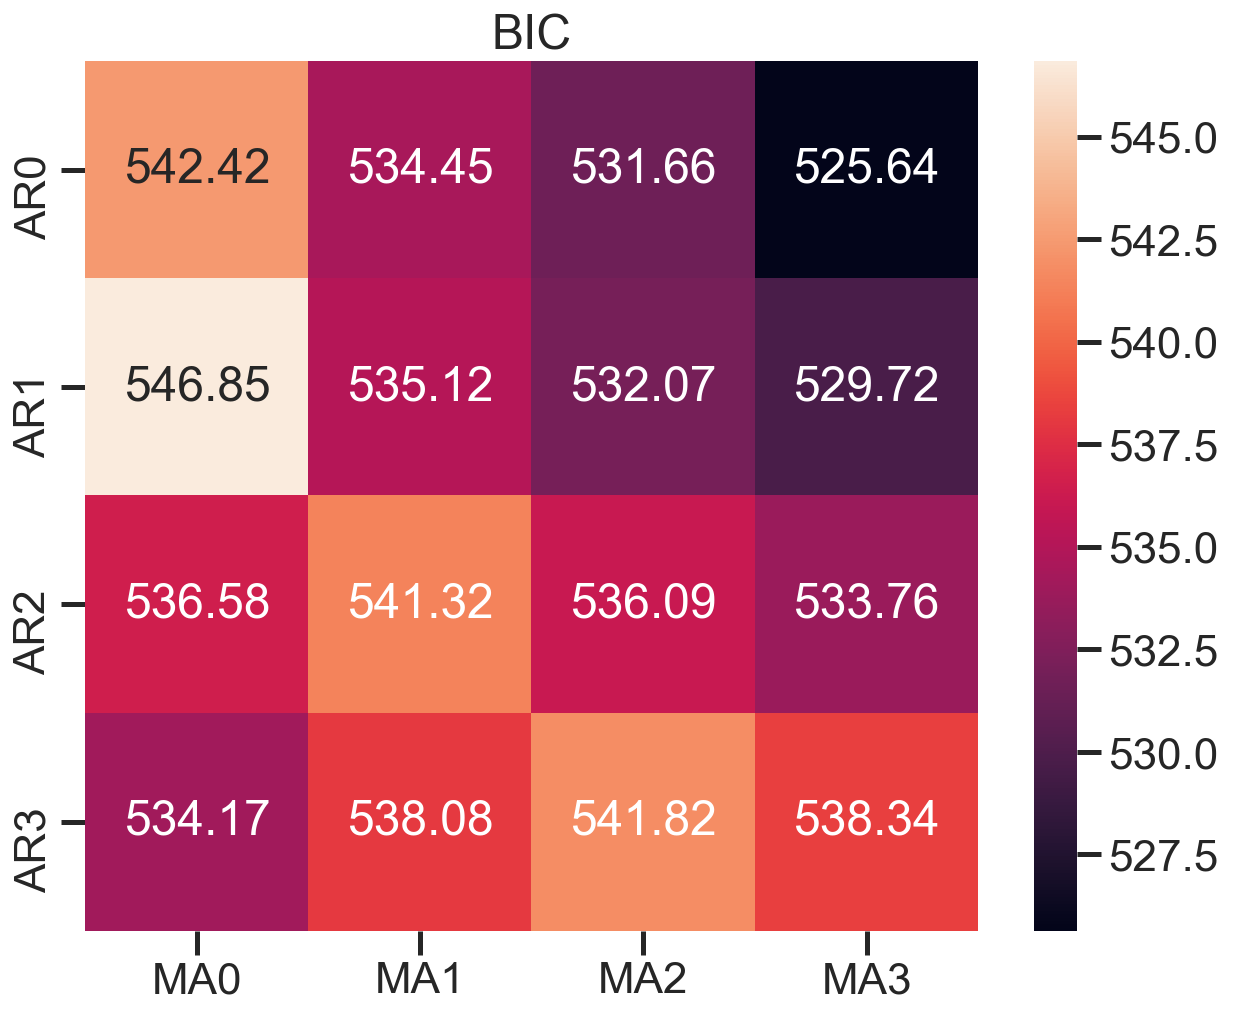

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(results_bic,
                 mask=results_bic.isnull(),
                 ax=ax,
                 annot=True,
                 fmt='.2f',
                 );
ax.set_title('BIC');

In [71]:
results_bic

,MA0,MA1,MA2,MA3
AR0,542.41992,534.45231,531.66067,525.64423
AR1,546.85208,535.12125,532.07248,529.71906
AR2,536.57788,541.31802,536.08599,533.76320
AR3,534.16850,538.07501,541.81825,538.33546


## 3.3 Model Diagnostic Checking

* Conduct visual inspection of the residual plots
* Residuals of a well-specified ARIMA model should mimic *Gaussian white noises*: the residuals should be uncorrelated with a Guassian distribution 
* Apparent patterns in the standardized residuals and the estimated ACF of the residuals give an indication that the model need to be re-specified
* The *results.plot_diagnostics()* function conveniently produce several plots to facilitate the investigation.
* The estimation results also come with some statistical tests

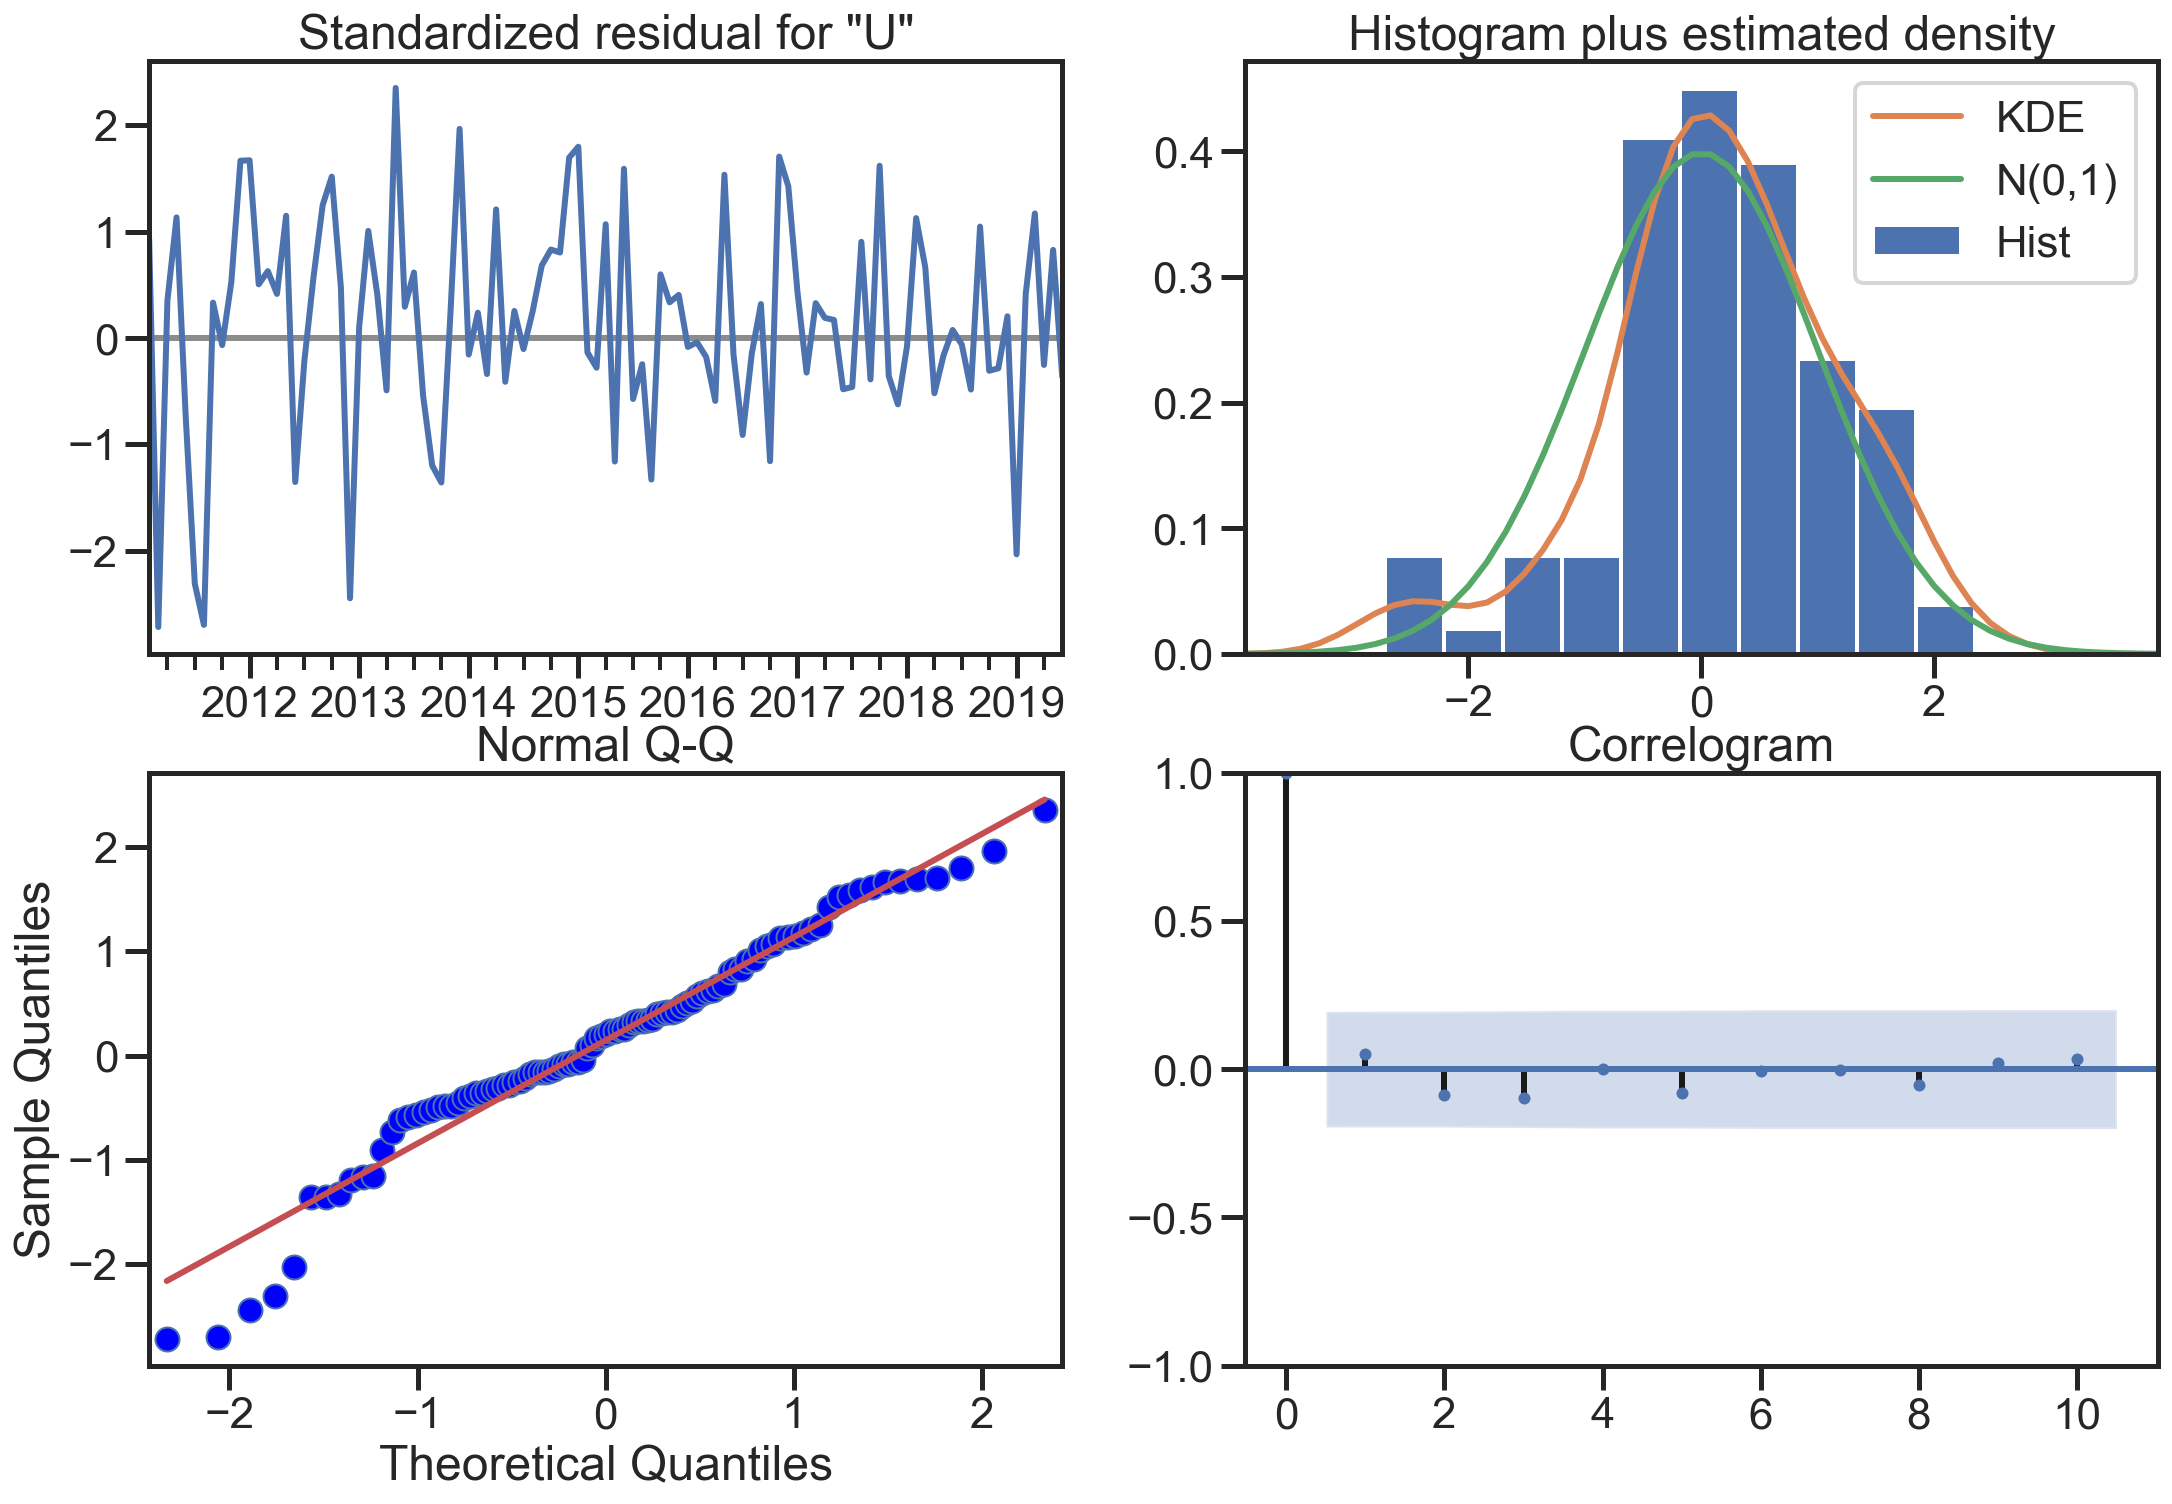

In [72]:
# Residual Diagnostics
_ = arima111_results.plot_diagnostics(figsize=(18,12))

## 3.3b Assumption Testing

**Note that the key results in these assumption tests are already summarized in the model estimation output, which I will discuss in my slides.**

In [73]:
# Re-run the above statistical tests, and more. To be used when selecting viable models.

het_method='breakvar'
norm_method='jarquebera'
sercor_method='ljungbox'

(het_stat, het_p) = arima111_results.test_heteroskedasticity(het_method)[0]
norm_stat, norm_p, skew, kurtosis = arima111_results.test_normality(norm_method)[0]
sercor_stat, sercor_p = arima111_results.test_serial_correlation(method=sercor_method)[0]
sercor_stat = sercor_stat[-1] # last number for the largest lag
sercor_p = sercor_p[-1] # last number for the largest lag

# check whether roots are outside the unit circle (we want them to be);
# will be True when AR is not used (i.e., AR order = 0)
arroots_outside_unit_circle = np.all(np.abs(arima111_results.arroots) > 1)
# will be True when MA is not used (i.e., MA order = 0)
maroots_outside_unit_circle = np.all(np.abs(arima111_results.maroots) > 1)

print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))

Test heteroskedasticity of residuals (breakvar): stat=0.397, p=0.009

Test normality of residuals (jarquebera): stat=6.675, p=0.036

Test serial correlation of residuals (ljungbox): stat=3.320, p=0.973

Test for all AR roots outside unit circle (>1): True

Test for all MA roots outside unit circle (>1): True


## 3.4 Produce Forecasts

In [74]:
# Construct in-sample fit
y_est = arima111_results.get_prediction()
y_est_mean = y_est.predicted_mean
y_est_ci = y_est.conf_int(alpha=0.05)

# Construct out-of-sample forecasts
y_fcast_h06 = arima111_results.get_forecast(steps=len(sentiment_test)).summary_frame()

In [75]:
y_est.summary_frame()

UMCSENT,mean,mean_se,mean_ci_lower,mean_ci_upper
2011-01-01,0.00000,1000.00633,-1959.97638,1959.97638
2011-02-01,74.19988,3.55685,67.22858,81.17118
2011-03-01,77.07974,3.52791,70.16518,83.99431
2011-04-01,68.56206,3.50872,61.68509,75.43903
2011-05-01,70.33426,3.49569,63.48284,77.18569
...,...,...,...,...
2019-02-01,92.36063,3.46492,85.56952,99.15174
2019-03-01,94.34061,3.46492,87.54950,101.13172
2019-04-01,98.07369,3.46492,91.28258,104.86480
2019-05-01,97.12802,3.46492,90.33691,103.91913


In [76]:
y_fcast_h06

UMCSENT,mean,mean_se,mean_ci_lower,mean_ci_upper
2019-07-01,98.05029,3.46492,91.25918,104.84139
2019-08-01,97.94888,4.50162,89.12587,106.77189
2019-09-01,97.88019,5.13640,87.81303,107.94734
2019-10-01,97.83366,5.58861,86.88018,108.78714
2019-11-01,97.80214,5.94199,86.15605,109.44823
2019-12-01,97.78080,6.23659,85.55730,110.00429


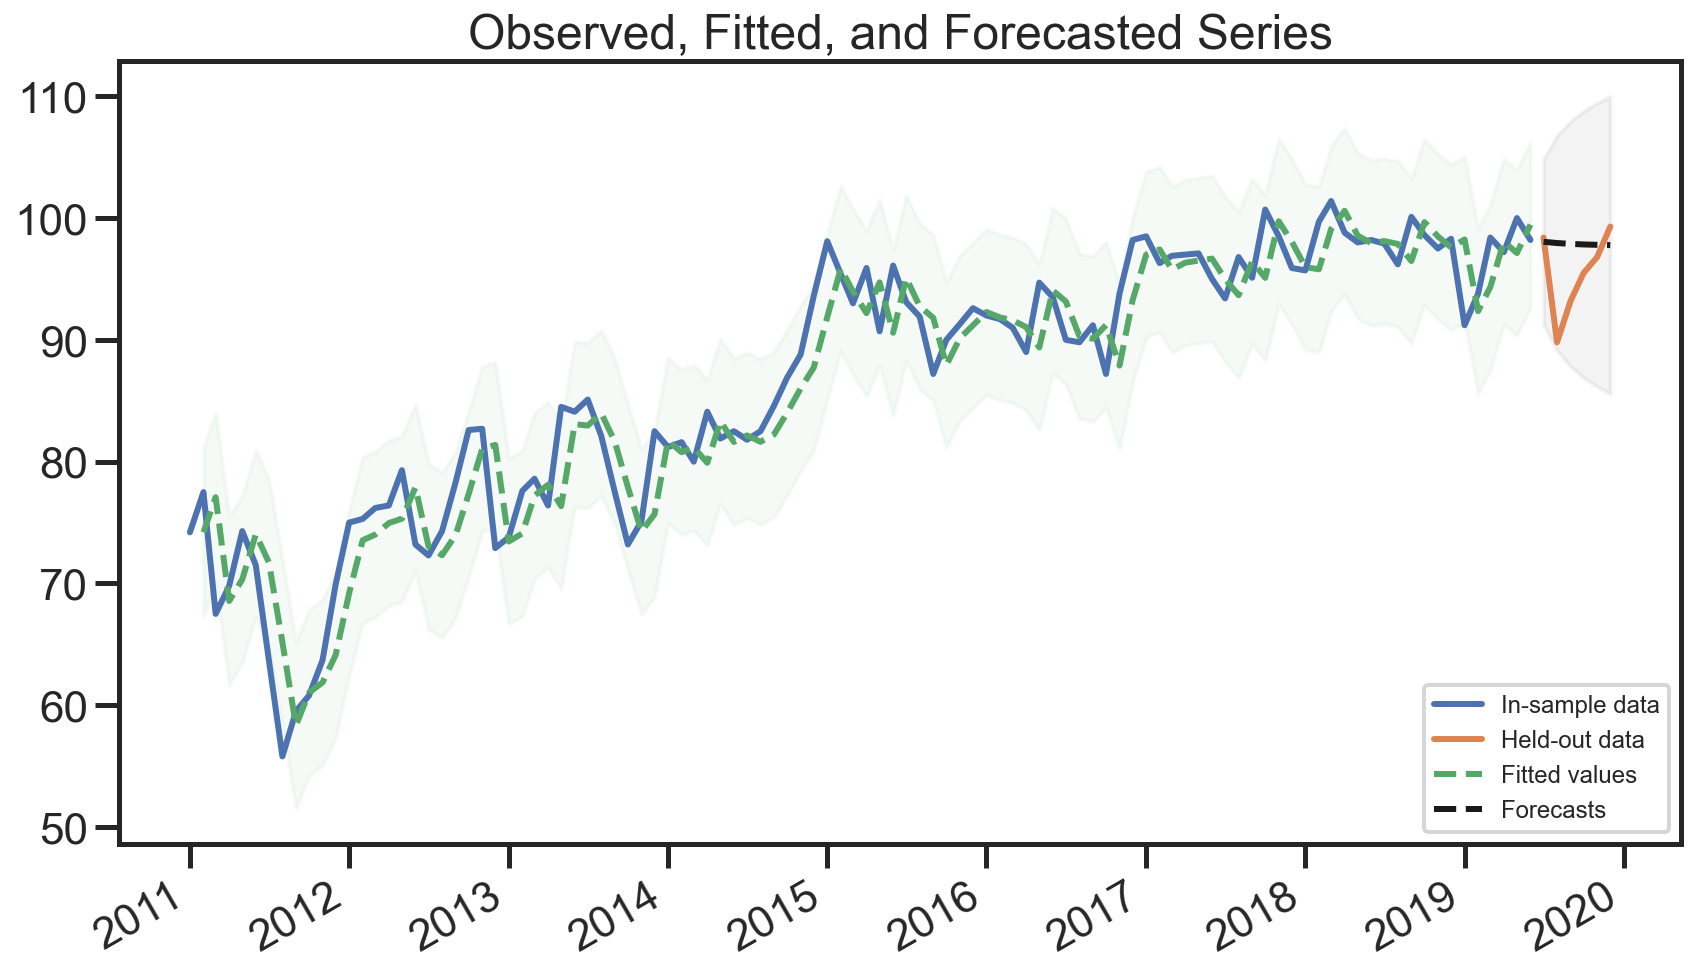

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
    
ax.set_title('Observed, Fitted, and Forecasted Series');
ax.set_ylabel('');
    
ax.plot(sentiment_train, label='In-sample data', linestyle='-')
ax.plot(sentiment_test, label='Held-out data', linestyle='-')

y_est_mean[1:].plot(ax=ax, style='g--', label='Fitted values')
y_fcast_h06['mean'].plot(ax=ax, style='k--', label='Forecasts')

ax.fill_between(y_est_mean[1:].index, 
                y_est_ci.iloc[1:, 0], 
                y_est_ci.iloc[1:, 1], 
                color='g', alpha=0.05)

ax.fill_between(y_fcast_h06.index, y_fcast_h06['mean_ci_lower'], y_fcast_h06['mean_ci_upper'], 
                color='k', alpha=0.05);

ax.legend(loc='lower right', prop={'size': 12})

## 3.4 Forecast Evaluation

**One could also calculate the following forecast evaluation metrics**

In [78]:
def get_rmse(y, y_hat):
    '''Root Mean Square Error
    '''
    mse = np.mean((y - y_hat)**2)
    return np.sqrt(mse)

def get_mape(y, y_hat):
    '''Mean Absolute Percent Error
    '''
    perc_err = (100*(y - y_hat))/y
    return np.mean(abs(perc_err))

def get_mase(y, y_hat):
    '''Mean Absolute Scaled Error
    '''
    abs_err = abs(y - y_hat)
    dsum=sum(abs(y[1:] - y_hat[1:]))
    t = len(y)
    denom = (1/(t - 1))* dsum
    return np.mean(abs_err/denom)

In [79]:
rmse = get_rmse(ts_test, pred_mean.ix[ts_test.index])
print(rmse)

mape = get_mape(ts_test, pred_mean.ix[ts_test.index])
print(mape)

mase = get_mase(ts_test, pred_mean.ix[ts_test.index])
print(mase)

NameError: name 'ts_test' is not defined

## Exericse:

Use `series2` and repeat the steps for developing an ARIMA model and use it for forecasting.

In [ ]:
# Import the csv file containing the series for the analysis

# Step 1a: Read the data series
series2_df = pd.read_csv('data/series2.csv', index_col=0, parse_dates=[0])

# Step 1b: Create the training and testing series before analyzing the series
n_sample = series2_df.shape[0]

n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train

series2_train = series2_df.iloc[:n_train]['value']
series2_test  = series2_df.iloc[n_train:]['value']
print(series2_train.shape)
print(series2_test.shape)
print("Training Series:", "\n", series2_train.tail(), "\n")
print("Testing Series:", "\n", series2_test.head())

In [ ]:
# Step 2a: Examine the basic structure of the data
print("Data shape:", series2_train.shape, "\n")
print("First 5 observations of the data series:", "\n", series2_train.head(), "\n")
print("Last 5 observations of the data series:", "\n", series2_train.tail())

In [ ]:
# Step 2b: Examine the series and use the visuals as clues for the choice of the orders of the ARIMA model
# Choose the number of lags you would like to display. Pick a number that is at least 20.

# tsplot(series2_train, title='Series 2', lags=?);

tsplot2(series2_train, title='Series 2', lags=YOUR_CODE_HERE);

In [ ]:
# Step 2c: Conduct any necessary transformations (such as natural log, difference, difference in natural log, etc )
# and repeat Step 2b

# YOUR CODE TO BE HERE

In [ ]:
# Step 3: Estimate an non-Seasonal ARIMA model
# Note: you will have to pick the orders (p,d,q)

# ex3_mod = sm.tsa.statespace.SARIMAX(series2_train, order=(?,?,?))
ex3_mod = sm.tsa.statespace.SARIMAX(series2_train, order=(YOUR_CODE_HERE))
ex3_arima_fit = ex3_mod.fit()
print(ex3_arima_fit.summary())

# Discuss your results

In [ ]:
# Step 4: Conduct model diagnostic check

ex3_arima_fit.plot_diagnostics(figsize=(16, 12));

# Discuss these plots

In [ ]:
# Step 5: Do a 5-step ahead forecast

# Step 5a: Produce the Forecast
# Step 5a: Plot the observed train and test series, fitted values, forecast values, and 95% confidence intervals
# associated with the fitted value and the forecast values
